In [74]:
from langchain.schema import Document
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from dotenv import load_dotenv
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph import add_messages, StateGraph, END
from pydantic import BaseModel, Field
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
from typing import Literal

In [75]:
load_dotenv()

True

In [76]:
embedding_function=OpenAIEmbeddings()

In [77]:
docs=[
    Document(
        page_content="Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With over 15 years of experience in professional athletics, Marcus established the gym to provide personalized fitness solutions for people of all levels. The gym spans 10,000 square feet and features state-of-the-art equipment.",
        metadata={"source": "about.txt"}
        ),
    Document(
        page_content="Peak Performance Gym is open Monday through Friday from 5:00 AM to 11:00 PM. On weekends, our hours are 7:00 AM to 9:00 PM. We remain closed on major national holidays. Members with Premium access can enter using their key cards 24/7, including holidays.",
        metadata={"source": "hours.txt"}
        ),
    Document(
        page_content="Our membership plans include: Basic (₹1,500/month) with access to gym floor and basic equipment; Standard (₹2,500/month) adds group classes and locker facilities; Premium (₹4,000/month) includes 24/7 access, personal training sessions, and spa facilities. We offer student and senior citizen discounts of 15% on all plans. Corporate partnerships are available for companies with 10+ employees joining.",
        metadata={"source": "membership.txt"}
        ),
    Document(
        page_content="Group fitness classes at Peak Performance Gym include Yoga (beginner, intermediate, advanced), HIIT, Zumba, Spin Cycling, CrossFit, and Pilates. Beginner classes are held every Monday and Wednesday at 6:00 PM. Intermediate and advanced classes are scheduled throughout the week. The full schedule is available on our mobile app or at the reception desk.",
        metadata={"source": "classes.txt"}
        ),
    Document(
        page_content="Personal trainers at Peak Performance Gym are all certified professionals with minimum 5 years of experience. Each new member receives a complimentary fitness assessment and one free session with a trainer. Our head trainer, Neha Kapoor, specializes in rehabilitation fitness and sports-specific training. Personal training sessions can be booked individually (₹800/session) or in packages of 10 (₹7,000) or 20 (₹13,000).",
        metadata={"source": "trainers.txt"}
        ),
    Document(
        page_content="Peak Performance Gym's facilities include a cardio zone with 30+ machines, strength training area, functional fitness space, dedicated yoga studio, spin class room, swimming pool (25m), sauna and steam rooms, juice bar, and locker rooms with shower facilities. Our equipment is replaced or upgraded every 3 years to ensure members have access to the latest fitness technology.",
        metadata={"source": "facilities.txt"}
        )
    ]

In [78]:
db=Chroma.from_documents(documents=docs,embedding=OpenAIEmbeddings())

In [79]:
retriever=db.as_retriever(search_type="mmr",search_kwargs={"k":3})

In [80]:
template="""
Answer the question based only on the following context: {context}
Question: {question}
"""

In [81]:
prompt=ChatPromptTemplate.from_template(template=template)
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='\nAnswer the question based only on the following context: {context}\nQuestion: {question}\n'), additional_kwargs={})])

In [82]:
llmLlama=ChatGroq(model="llama-3.1-8b-instant")

In [83]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [84]:
rag_chain=prompt | llmLlama

In [85]:
class AgentState(TypedDict):
    messages: Annotated[list[BaseMessage],add_messages]
    documents: list[Document]
    on_topic:str

In [86]:
class GradeQuestion(BaseModel):
    """
        Boolean Value to check whether a question is related to the peak Performance Gym
    """
    score: Literal[True,False] = Field(description="Question is about Gym? If yes -> True if not -> False ")

In [87]:
def question_classifier(state: AgentState):
    question=state["messages"][-1].content
    system_message="""
        You are a classifier that determines whether a user's question is about one of the following topics

        1. Gym History & Founder
        2. Operating Hours
        3. Membership Plans
        4. Fitness Classes
        5. Personal Trainers
        6. Facilities & Equipment

        If the question is about any of these topics, respond with 'Yes', otherwise respond with 'No'.
    """
    grade_prompt=ChatPromptTemplate.from_messages(messages=[
        ("system", system_message),
        ("human","User Question: {question}")
    ])
    structured_llm_llama=llmLlama.with_structured_output(schema=GradeQuestion)
    grader_llm=grade_prompt | structured_llm_llama

    result=grader_llm.invoke(input={"question":question})
    state["on_topic"]=result.score
    
    return state

In [88]:
def on_topic_router(state:AgentState):
    on_topic=state["on_topic"]
    return "on_topic" if on_topic else "off_topic"

In [89]:
def retrieve(state:AgentState):
    question=state["messages"][-1].content
    documents=retriever.invoke(input=question)
    state["documents"]=documents
    return state

In [90]:
def generate_answer(state:AgentState):
    question=state["messages"][-1].content
    documents=state["documents"]
    generation=rag_chain.invoke(input={
        "context": format_docs(docs=documents),
        "question":question
    })
    state["messages"]=AIMessage(content=generation.content)
    return state

In [91]:
def off_topic_response(state: AgentState):
    state["messages"]=AIMessage(
        content="I am sorry, I cannot answer this question since this question is out of the topic"
    )
    return state

In [92]:
workflow=StateGraph(state_schema=AgentState)

In [93]:
workflow.add_node(node="topic_decision", action=question_classifier)

In [94]:
workflow.add_node(node="off_topic_response",action=off_topic_response)

In [95]:
workflow.add_node(node="retrieve", action=retrieve)

In [96]:
workflow.add_node(node="generate_answer", action=generate_answer)

In [97]:
workflow.add_conditional_edges(
    source="topic_decision",path=on_topic_router, path_map={
        "on_topic":"retrieve",
        "off_topic": "off_topic_response"
    }
)

In [98]:
workflow.add_edge(start_key="retrieve", end_key="generate_answer")

In [99]:
workflow.add_edge(start_key="generate_answer", end_key=END)

In [100]:
workflow.add_edge(start_key="off_topic_response", end_key=END)

In [101]:
workflow.set_entry_point(key="topic_decision")

In [102]:
graph=workflow.compile()

In [103]:
print(graph.get_graph().draw_ascii())

                   +-----------+                      
                   | __start__ |                      
                   +-----------+                      
                         *                            
                         *                            
                         *                            
                +----------------+                    
                | topic_decision |                    
                +----------------+                    
                 ..             ...                   
              ...                  ...                
            ..                        ..              
    +----------+                        ..            
    | retrieve |                         .            
    +----------+                         .            
          *                              .            
          *                              .            
          *                              .            
+---------

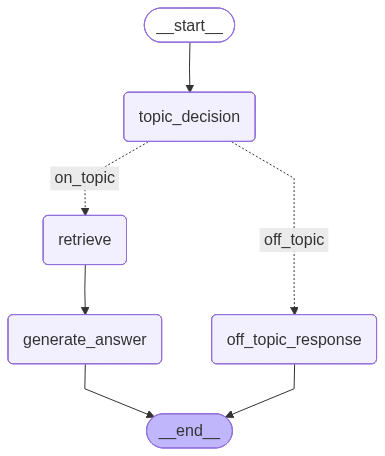

In [104]:
display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)
))

In [105]:
graph.invoke(input={
    "messages":[HumanMessage(content="Who is the owner of this gym and what are the timings?")]
})

{'messages': [HumanMessage(content='Who is the owner of this gym and what are the timings?', additional_kwargs={}, response_metadata={}, id='71ae643e-db7b-48e2-87ca-fc19ec525a62'),
  AIMessage(content='The owner of Peak Performance Gym is Marcus Chen, a former Olympic athlete. \n\nAs for the timings, the gym is open:\n\n- Monday to Friday: 5:00 AM to 11:00 PM\n- Weekends: 7:00 AM to 9:00 PM\n- Members with Premium access can enter 24/7, but the gym itself is closed on major national holidays.', additional_kwargs={}, response_metadata={}, id='722b9687-b243-4407-8300-5e0b8fce16b3')],
 'documents': [Document(metadata={'source': 'hours.txt'}, page_content='Peak Performance Gym is open Monday through Friday from 5:00 AM to 11:00 PM. On weekends, our hours are 7:00 AM to 9:00 PM. We remain closed on major national holidays. Members with Premium access can enter using their key cards 24/7, including holidays.'),
  Document(metadata={'source': 'about.txt'}, page_content='Peak Performance Gym w

In [106]:
graph.invoke(input={
    "messages":[HumanMessage(content="What does the company Apple do?")]
})

{'messages': [HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={}, id='94bc5479-ece2-4596-a0d0-b44b5e401510'),
  AIMessage(content='I am sorry, I cannot answer this question since this question is out of the topic', additional_kwargs={}, response_metadata={}, id='ad9a56f8-fd13-4d21-91ff-97c5570fe4d5')],
 'on_topic': False}

In [107]:
graph.invoke(input={
    "messages":[HumanMessage(content="Mention few things about Peak Performance")]
})

{'messages': [HumanMessage(content='Mention few things about Peak Performance', additional_kwargs={}, response_metadata={}, id='50dc277e-4da6-440a-8859-b725c94faf0f'),
  AIMessage(content='Here are a few things about Peak Performance Gym:\n\n1. Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen.\n2. The gym spans 10,000 square feet and features state-of-the-art equipment.\n3. Group fitness classes include Yoga, HIIT, Zumba, Spin Cycling, CrossFit, and Pilates, with classes available for all levels.\n4. Personal trainers at the gym are certified professionals with a minimum of 5 years of experience.\n5. Each new member receives a complimentary fitness assessment and one free session with a trainer.\n6. Personal training sessions can be booked individually or in packages of 10 or 20 sessions.', additional_kwargs={}, response_metadata={}, id='6c4e44cd-a718-4f31-a24c-f4d1e0552e46')],
 'documents': [Document(metadata={'source': 'about.txt'}, page_content='Peak Pe